In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# %matplotlib inline
plt.style.use('ggplot')
from IPython.display import display

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# EDA
定位到目录

In [3]:
%pwd
#%cd Kaggle/Titanic/

'D:\\Projects\\DataAnalysis\\Kaggle\\Titanic-#1'

## 数据概览

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"train.shape: {train.shape},  test.shape: {test.shape}.")

train.shape: (891, 12),  test.shape: (418, 11).


In [5]:
# 将 PassengerId 设置为index，它对于预测没有帮助
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)
display(train.head())
display(train.info())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

特征说明：
+ Pclass：Ticket Class, 取值 1 = 1st, 2 = 2nd, 3 = 3rd
+ Name: 姓名
+ Sex: 性别
+ Age: 年龄
+ SibSp: 船上有兄弟(Silbings)或配偶(Spouse)同行的人数    
兄弟和配偶关系的范围：brother, sister, stepbrother, stepsister, husband, wife
+ Parch: 船上有父母(Parents)或者子女(Children)同行的人数   
关系范围：nanny, mother, father, daughter, son, stepdaughter, stepson
+ Ticket: 船票号码
+ Fare: 船票费用
+ Cabin: 船舱编号
+ Embarked: 登船的码头，C = Cherbourg, Q = Queenstown, S = Southampton

预测变量：Survived: 0=No, 1=Yes

## 数据可视化

二分类问题，根据直觉，先检查下各个特征在预测变量上的分布。  
1. 这里不考虑Name，因为直觉上它和是否幸存没有关系。  
1. 对于船票编号Ticket，也不考虑。
1. 对于船舱编号Cabin，它的缺失值个数太多，也暂时不考虑。

In [9]:
# 为了方便绘图，需要对一些离散特征的类型做一下转换
# train = train.astype({'Sibsp': str, ''})
# train.info()

### 使用seaborn做EDA

<AxesSubplot:xlabel='Age', ylabel='Survived'>

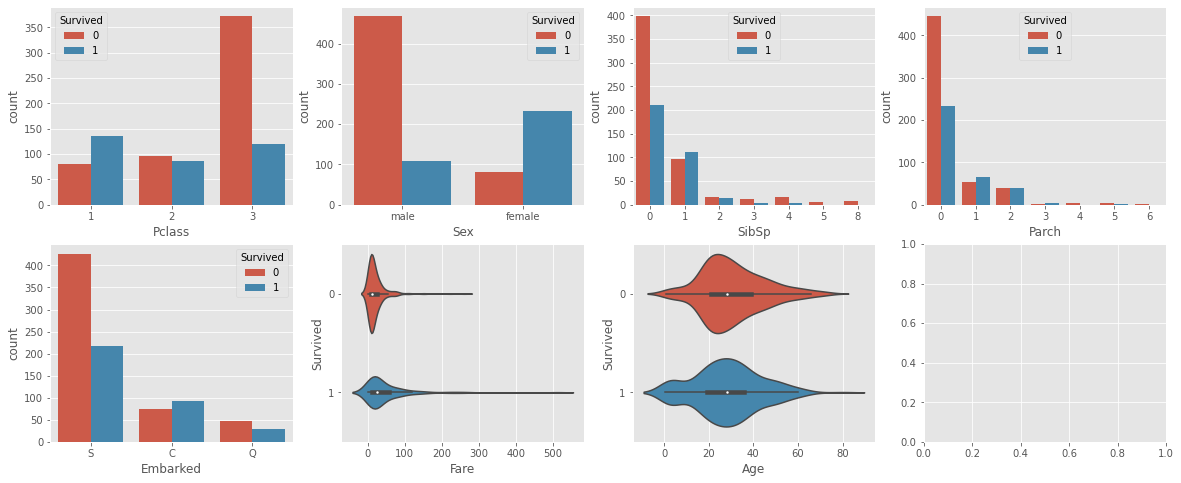

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

sns.countplot(data=train, x='Pclass', hue='Survived', ax=axes[0,0])
sns.countplot(data=train, x='Sex', hue='Survived', ax=axes[0,1])
sns.countplot(data=train, x='SibSp', hue='Survived', ax=axes[0,2])
sns.countplot(data=train, x='Parch', hue='Survived', ax=axes[0,3])
sns.countplot(data=train, x='Embarked', hue='Survived', ax=axes[1,0])
sns.violinplot(data=train, y='Survived', x='Fare', orient='h', ax=axes[1,1])
sns.violinplot(data=train, y='Survived', x='Age', orient='h', ax=axes[1,2])

### 使用plotly做EDA

可以看出，使用plotly的话，需要自己做不少数据处理的工作，没有seaborn方便。

In [38]:
pclass_bar = train.groupby(['Pclass', 'Survived'], as_index=False).size()
pclass_bar['Survived'] = pclass_bar['Survived'].astype(str)
subfig_1 = px.bar(data_frame=pclass_bar, x='Pclass', y='size', color='Survived', barmode='group')
# subfig_1.show()

In [42]:
sex_bar = train.groupby(['Sex', 'Survived'], as_index=False).size()
sex_bar['Survived'] = sex_bar['Survived'].astype(str)
subfig_2 = px.bar(data_frame=sex_bar, x='Sex', y='size', color='Survived', barmode='group')
subfig_2.update_traces(showlegend=False)
# subfig_2.show()
print()

In [43]:
sibsp_bar = train.groupby(['SibSp', 'Survived'], as_index=False).size()
sibsp_bar['Survived'] = sibsp_bar['Survived'].astype(str)
subfig_3 = px.bar(data_frame=sibsp_bar, x='SibSp', y='size', color='Survived', barmode='group')
subfig_3.update_traces(showlegend=False)
# subfig_3.show()
print()

In [44]:
parch_bar = train.groupby(['Parch', 'Survived'], as_index=False).size()
parch_bar['Survived'] = parch_bar['Survived'].astype(str)
subfig_4 = px.bar(data_frame=parch_bar, x='Parch', y='size', color='Survived', barmode='group')
subfig_4.update_traces(showlegend=False)
# subfig_4.show()
print()

In [45]:
embarked_bar = train.groupby(['Embarked', 'Survived'], as_index=False).size()
embarked_bar['Survived'] = embarked_bar['Survived'].astype(str)
subfig_5 = px.bar(data_frame=embarked_bar, x='Embarked', y='size', color='Survived', barmode='group')
subfig_5.update_traces(showlegend=False)
# subfig_5.show()
print()

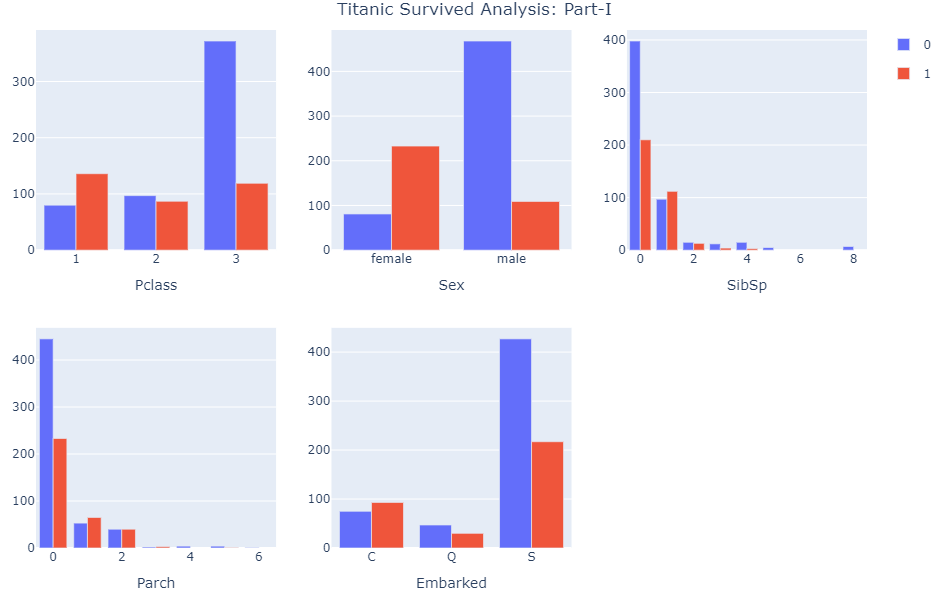

In [52]:
fig_plotly = make_subplots(rows=2, cols=3)

fig_plotly.add_traces(subfig_1['data'], rows=1, cols=1)
fig_plotly.add_traces(subfig_2['data'], rows=1, cols=2)
fig_plotly.add_traces(subfig_3['data'], rows=1, cols=3)
fig_plotly.add_traces(subfig_4['data'], rows=2, cols=1)
fig_plotly.add_traces(subfig_5['data'], rows=2, cols=2)
# fig_plotly.add_traces(subfig_6['data'], rows=2, cols=2)
# fig_plotly.add_traces(subfig_7['data'], rows=2, cols=3)

fig_plotly.update_layout(
    showlegend=True,
    width=960, height=600, autosize=False,
    margin=dict(l=30, r=30, t=30, b=30)
)

fig_plotly.update_layout(xaxis_title_text='Pclass', xaxis2_title_text='Sex', xaxis3_title_text='SibSp',
                         xaxis4_title_text='Parch', xaxis5_title_text='Embarked')

fig_plotly.update_layout(title=dict(text='Titanic Survived Analysis: Part-I', x=0.5))

In [56]:
df = train.astype({'Survived': str})
subfig_6 = px.violin(data_frame=df, x='Fare', color='Survived')
# subfig_6.update_traces(showlegend=False)
# subfig_6.show()
subfig_7 = px.violin(data_frame=df, x='Age', color='Survived')
subfig_7.update_traces(showlegend=False)
# subfig_7.show()
print()

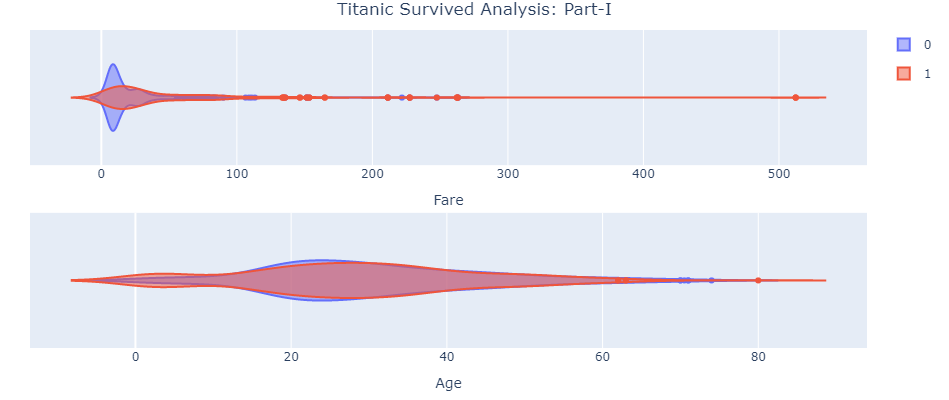

In [58]:
fig_plotly = make_subplots(rows=2, cols=1)
fig_plotly.add_traces(subfig_6['data'], rows=1, cols=1)
fig_plotly.add_traces(subfig_7['data'], rows=2, cols=1)
fig_plotly.update_layout(
    width=600, height=400, autosize=False,
    margin=dict(l=30, r=30, t=30, b=30),
    title=dict(text='Titanic Survived Analysis: Part-I', x=0.5),
    xaxis_title_text='Fare', xaxis2_title_text='Age'
)

## EDA初步结论

看起来，Pclass, Sex, SibSp, Parch, Embarked 这几个变量和是否存活有一定关系，而 Fare, Age 这两个特征似乎和是否存活没有关系。

所以后续的分析，**只选择 Pclass, Sex, SibSp, Parch, Embarked 这 5 个特征**。

In [7]:
cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
train = train[cols+['Survived']]
test = test[cols]

print(f"train.shape: {train.shape},  test.shape: {test.shape}.")

train.shape: (891, 6),  test.shape: (418, 5).


# 数据预处理

## 缺失值检查

In [24]:
def miss_summary(df, all=True):
    """
    用于统计DF中各列的缺失值信息和占比。
    all: 是否返回所有的列，False只返回有缺失值的列
    """
    miss_num = df.isnull().sum()
    if not all:
        # 只展示有缺失值的特征
        miss_num = miss_num[miss_num > 0]
    # 总样本量
    total = df.shape[0]
    # 缺失占比
    miss_percent = miss_num/total*100
    # 各个特征的取值
    cols_values = pd.Series({col: df[col].unique() for col in df})
    # 汇总信息
    miss_info = pd.concat([miss_num, miss_percent, df.dtypes, cols_values], axis=1, keys=['miss_num', 'miss_percent','dtype', 'values'])
    miss_info['total'] = total
    miss_info = miss_info[['miss_num','total','miss_percent','dtype', 'values']]
    miss_info.dropna(inplace=True)
    # 降序排列，同时设置小数点的位数
    miss_info = miss_info.sort_values(by=['miss_num'],ascending=False).round(decimals=3)
    return miss_info

In [25]:
miss_info = miss_summary(train[cols])
miss_info

,miss_num,total,miss_percent,dtype,values
Embarked,2,891,0.224,object,"[S, C, Q, nan]"
Pclass,0,891,0.000,int64,"[3, 1, 2]"
Sex,0,891,0.000,object,"[male, female]"
SibSp,0,891,0.000,int64,"[1, 0, 3, 4, 2, 5, 8]"
Parch,0,891,0.000,int64,"[0, 1, 2, 5, 3, 4, 6]"


这里只是简单的使用众数进行缺失值填充操作。

In [30]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='most_frequent')
imp.fit(train[cols])
train[cols] = imp.transform(train[cols])

In [31]:
miss_summary(train[cols])

,miss_num,total,miss_percent,dtype,values
Pclass,0,891,0.0,int64,"[3, 1, 2]"
Sex,0,891,0.0,object,"[male, female]"
SibSp,0,891,0.0,int64,"[1, 0, 3, 4, 2, 5, 8]"
Parch,0,891,0.0,int64,"[0, 1, 2, 5, 3, 4, 6]"
Embarked,0,891,0.0,object,"[S, C, Q]"


In [32]:
train.head()

,Pclass,Sex,SibSp,Parch,Embarked,Survived
PassengerId,,,,,,
1,3,male,1,0,S,0
2,1,female,1,0,C,1
3,3,female,0,0,S,1
4,1,female,1,0,S,1
5,3,male,0,0,S,0


In [34]:
# 测试集没有缺失值
miss_summary(test)

,miss_num,total,miss_percent,dtype,values
Pclass,0,418,0.0,int64,"[3, 2, 1]"
Sex,0,418,0.0,object,"[male, female]"
SibSp,0,418,0.0,int64,"[0, 1, 2, 3, 4, 5, 8]"
Parch,0,418,0.0,int64,"[0, 1, 3, 2, 4, 6, 5, 9]"
Embarked,0,418,0.0,object,"[Q, S, C]"


# 特征工程

## 分类特征编码